# Leios simulation analysis at tag `bwbush/2025w32b`

## Set up

### Load packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

### Define utility functions

In [2]:
sort_factors <- function(fs, ascending=TRUE) {
    xs <- fs[as.numeric(sub(" .*$", "", fs)) %>% order]
    if (ascending)
        xs
    else
        rev(xs)
}

## Experiment: Haskell vs Rust for Linear Leios without modeling transactions

In [3]:
readLines("ols.hash")

[1] "33078f51f7489cbda3728a328977492dd66923b9"

In [4]:
readLines("sim-cli.hash")

[1] "6af1cf04bedcafb88d8adbdf2e7db9fc0d09d52c"

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [5]:
if (file.exists("results/lifecycle.Rdata")) {
    load(file="results/lifecycle.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    lifecycle <- fread("results/lifecycle.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(lifecycle, sampleSize, file="results/lifecycle.R")
}
setnames(lifecycle, old="Kind", new="Message")
lifecycle[, `Stage length`:=factor(`Stage length`, levels=sort_factors(lifecycle[, unique(`Stage length`)]))]
lifecycle %>% summary

Loaded Rdata file: sampleSize = 1 


   Simulator     Variant                Network      Bandwidth  
 Haskell: 45   linear:337   topo-default-100:337   50 Mb/s:337  
 Rust   :292                                                    
                                                                
                                                                
                                                                
                                                                
                                                                
       Stage length         EB rate      Max EB size    Tx size   
 8 slot/stage:337   2.5 EB/stage:337   10 MB/EB:337   0 B/Tx:337  
                                                                  
                                                                  
                                                                  
                                                                  
                                                                  
           

In [6]:
label <- lifecycle[, unique(paste(`Variant`, `Network`, `Bandwidth`, `Stage length`, `EB rate`, `Max EB size`, `Tx size`, `Throughput`, sep=", "))]
label

[1] "linear, topo-default-100, 50 Mb/s, 8 slot/stage, 2.5 EB/stage, 10 MB/EB, 0 B/Tx, 0.150 TxMB/s"

In [7]:
fixed <- c("Variant", "Network", "Bandwidth", "Stage length", "EB rate", "Max EB size", "Tx size", "Throughput")

In [8]:
varied <- c("Simulator")

In [9]:
facet_varied <- function(scales="free_y", wide=FALSE) {
    if (wide)
        facet_grid(. ~ `Simulator`, scales=scales)
    else
        facet_grid(`Simulator` ~ ., scales=scales)
}

In [10]:
simFinish <- lifecycle[, unique(`Sim stop [s]`)]

#### Size of persisted data

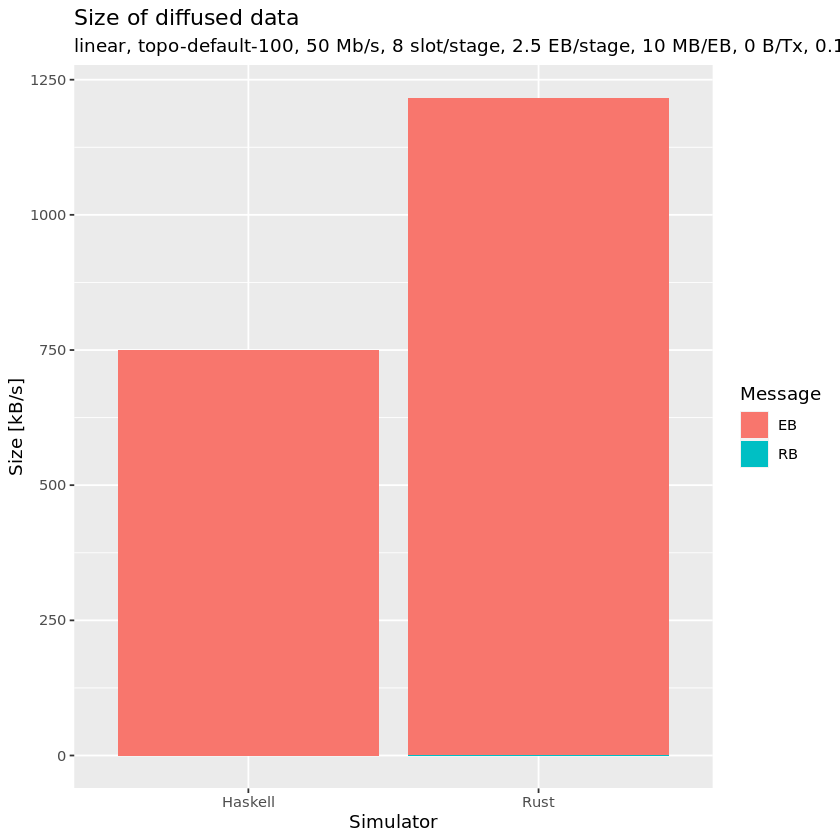

In [11]:
ggplot(
    lifecycle[`Message` != "TX",
        .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600),
        c(varied, "Message")
    ],
    aes(x=!!sym(varied), y=`Size [kB/s]`, fill=`Message`)
) + geom_bar(stat="identity") +
    ggtitle("Size of diffused data", subtitle=label)

In [12]:
ggsave("plots/sizes.png", units="in", dpi=150, width=16, height=8)

#### Release memory

In [13]:
rm(lifecycle)

In [14]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,918167,49.1,1780507,95.1,1354928,72.4
Vcells,1686577,12.9,8388608,64.0,2582269,19.8


### Resource usage

In [15]:
if (file.exists("results/resources.Rdata")) {
    load(file="results/resources.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    resources <- fread("results/resources.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(resources, file="results/resources.Rdata")
}
resources[, `Stage length`:=factor(`Stage length`, levels=sort_factors(resources[, unique(`Stage length`)]))]
resources %>% summary

Loaded Rdata file: sampleSize = 1 


   Simulator     Variant                Network      Bandwidth  
 Haskell:100   linear:200   topo-default-100:200   50 Mb/s:200  
 Rust   :100                                                    
                                                                
                                                                
                                                                
                                                                
                                                                
       Stage length         EB rate      Max EB size    Tx size   
 8 slot/stage:200   2.5 EB/stage:200   10 MB/EB:200   0 B/Tx:200  
                                                                  
                                                                  
                                                                  
                                                                  
                                                                  
           

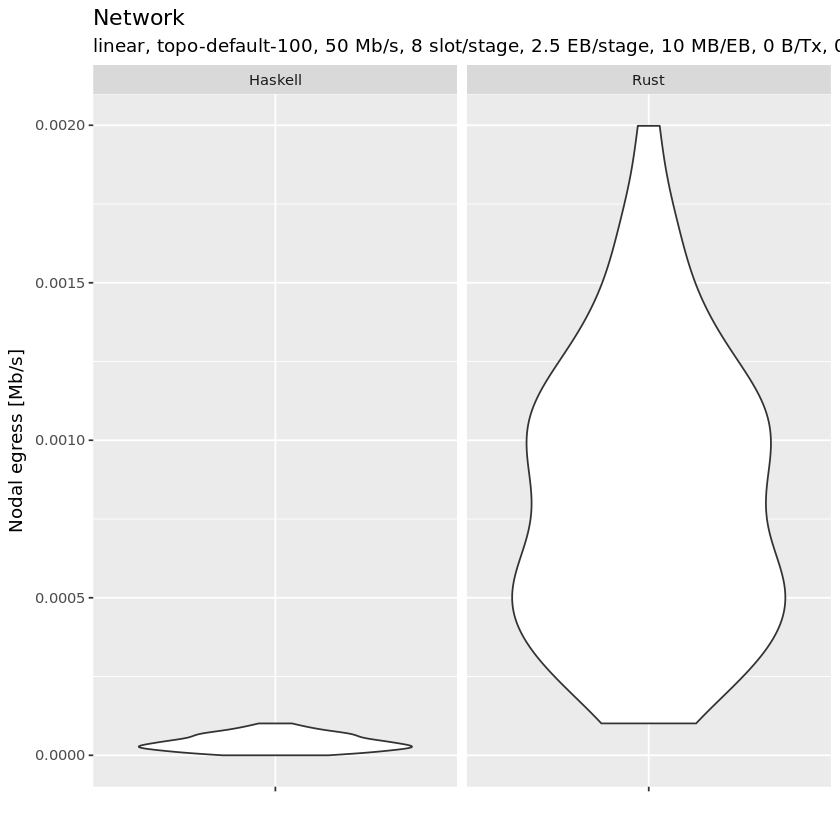

In [16]:
ggplot(
    substitute(
        resources[, .(`Varied`, `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
        env=list(`Varied`=sym(varied))
    ) %>% eval,
    aes(x="", y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    facet_varied(wide=TRUE) +
    xlab("") +
    ggtitle("Network", label)

In [17]:
ggsave("plots/network.png", units="in", dpi=150, width=16, height=8)

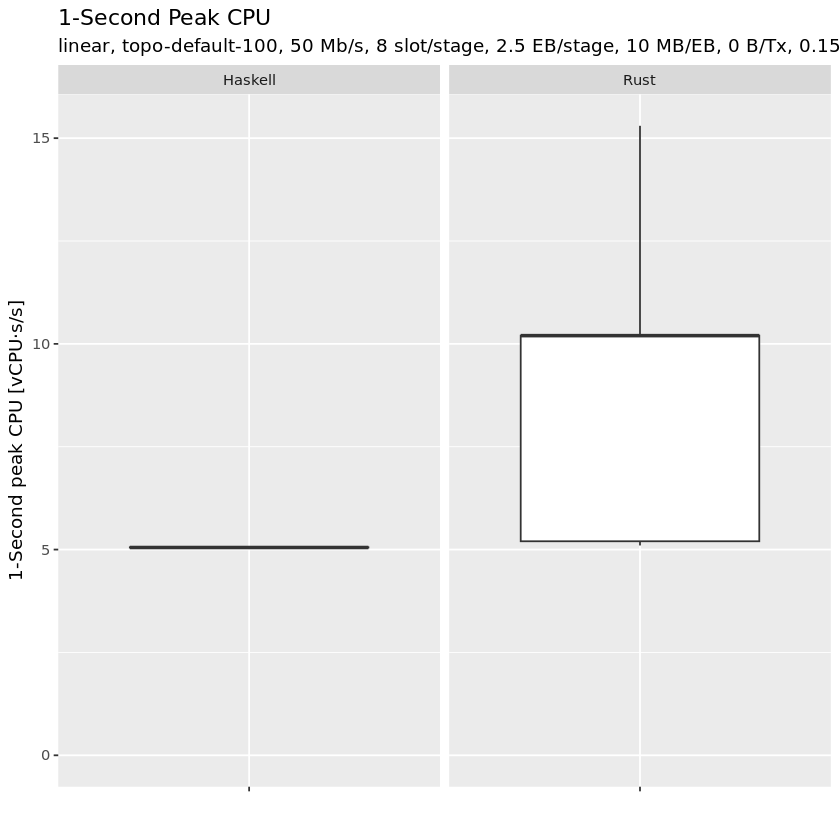

In [18]:
ggplot(
    substitute(
        resources[, .(`Varied`, `Node`, `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
        env=list(`Varied`=sym(varied))
    ) %>% eval,
    aes(x="", y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_varied(wide=TRUE) +
    xlab("") +
    ggtitle("1-Second Peak CPU", label)

In [19]:
ggsave("plots/cpu-peak.png", units="in", dpi=150, width=16, height=8)

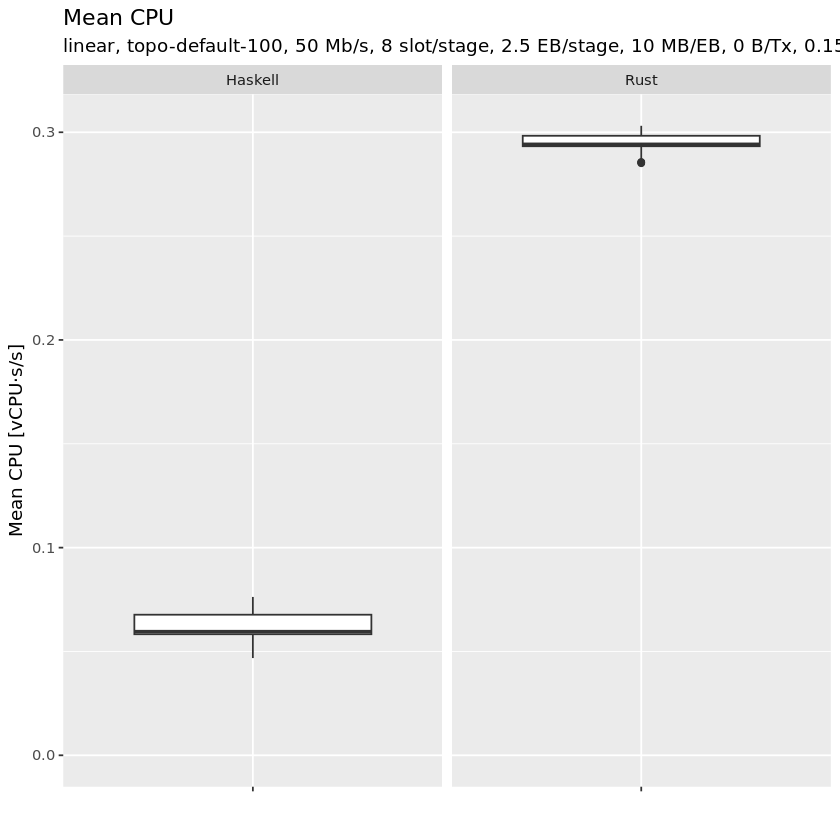

In [20]:
ggplot(
    substitute(
        resources[, .(`Varied`, `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish)], 
        env=list(`Varied`=sym(varied))
    ) %>% eval,
    aes(x="", y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_varied(wide=TRUE) +
    xlab("") +
    ggtitle("Mean CPU", label)

In [21]:
ggsave("plots/cpu-mean.png", units="in", dpi=150, width=16, height=8)

#### Release memory

In [22]:
rm(resources)

In [23]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,977900,52.3,1780507,95.1,1780507,95.1
Vcells,1787040,13.7,8388608,64.0,3105458,23.7


### Receipt of messages

#### Read results

In [24]:
if (file.exists("results/receipts.Rdata")) {
    load("results/receipts.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    receipts <- fread("results/receipts.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(receipts, file="results/receipts.Rdata")
}
setnames(receipts, old="Kind", new="Message")
receipts[, `Stage length`:=factor(`Stage length`, levels=sort_factors(receipts[, unique(`Stage length`)]))]
receipts %>% summary

Loaded Rdata file: sampleSize = 1 


   Simulator       Variant                  Network        Bandwidth    
 Haskell:12794   linear:38248   topo-default-100:38248   50 Mb/s:38248  
 Rust   :25454                                                          
                                                                        
                                                                        
                                                                        
                                                                        
                                                                        
       Stage length           EB rate        Max EB size      Tx size     
 8 slot/stage:38248   2.5 EB/stage:38248   10 MB/EB:38248   0 B/Tx:38248  
                                                                          
                                                                          
                                                                          
                                         

In [25]:
kinds <- receipts[, unique(`Message`) %>% sort]
kinds

[1] EB RB VT
Levels: EB RB VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [26]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        substitute(
            rs[, .(`Varied`, `Network`, `Elapsed [s]`, `Minute created`=factor(floor(`Generated [s]`/60)))],
            env=list(`Varied`=sym(varied))
        ) %>% eval,
        aes(x=`Elapsed [s]`, fill=`Minute created`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_varied(scales=scales) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

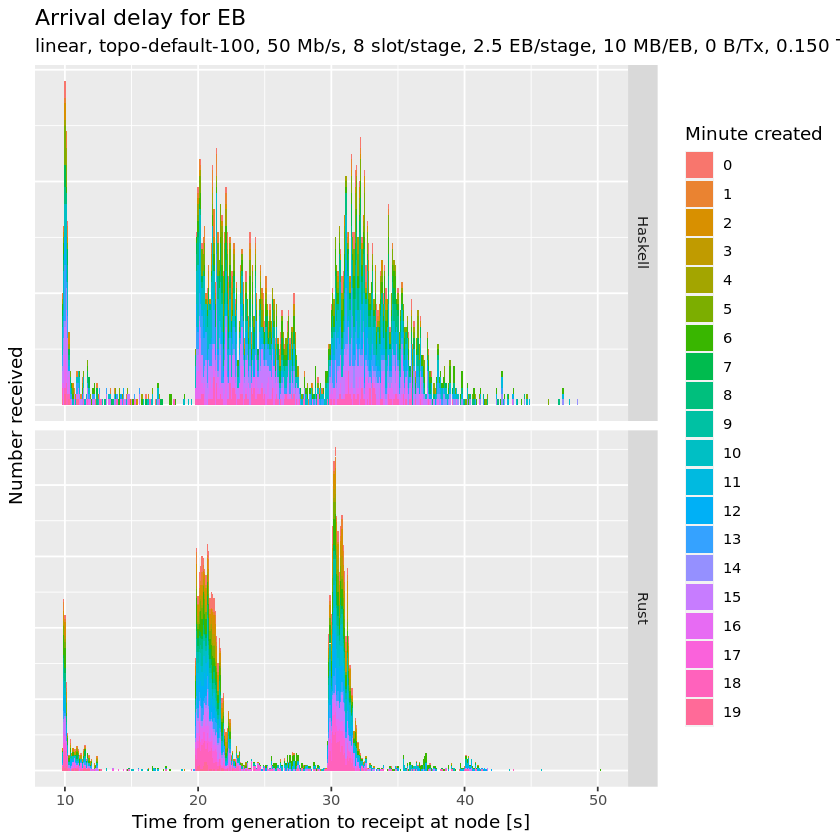

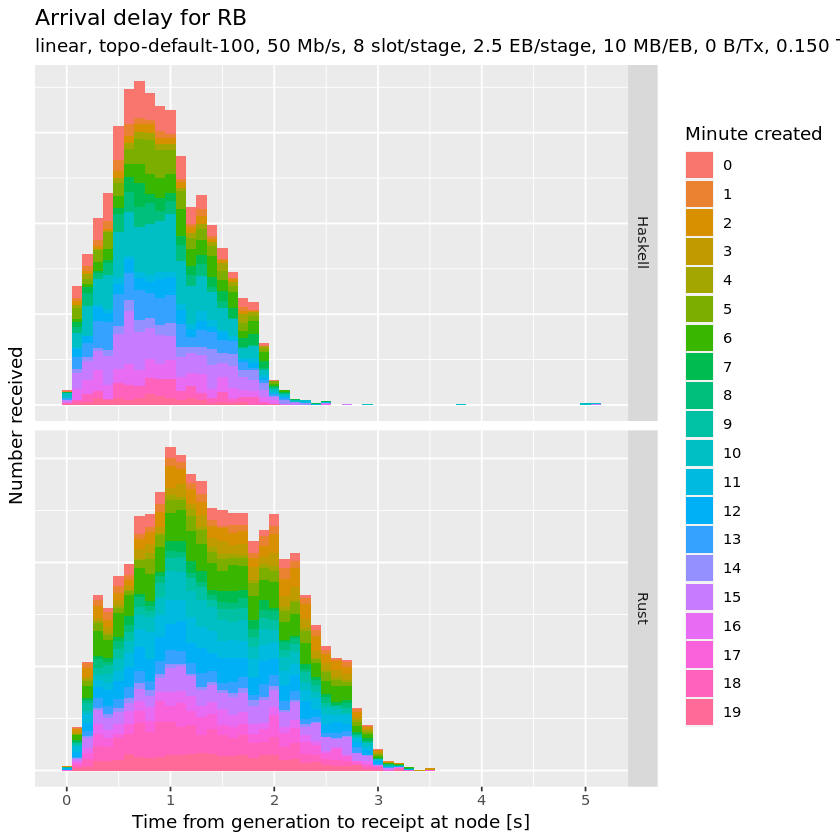

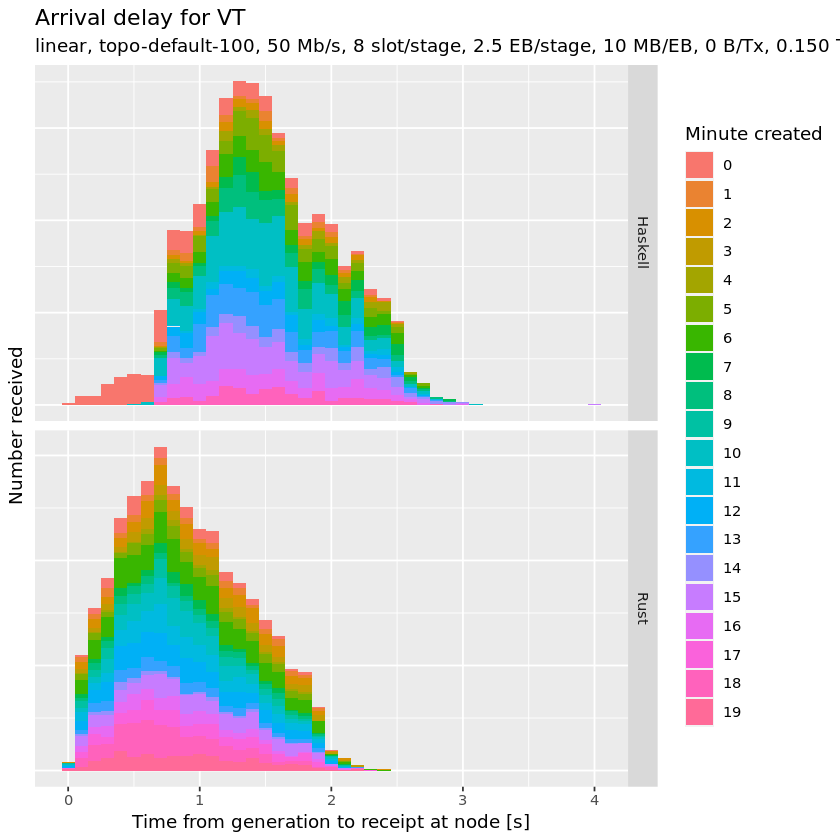

In [27]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Message` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/elapsed-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [28]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        substitute(
            rs[,
                .(`Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9/sampleSize),
                by=.(`Varied`, `Network`, `Slot`=floor(`Received [s]`), `Message`)
            ],
            env=list(`Varied`=sym(varied))
        ) %>% eval,
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_varied(scales=scales) +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

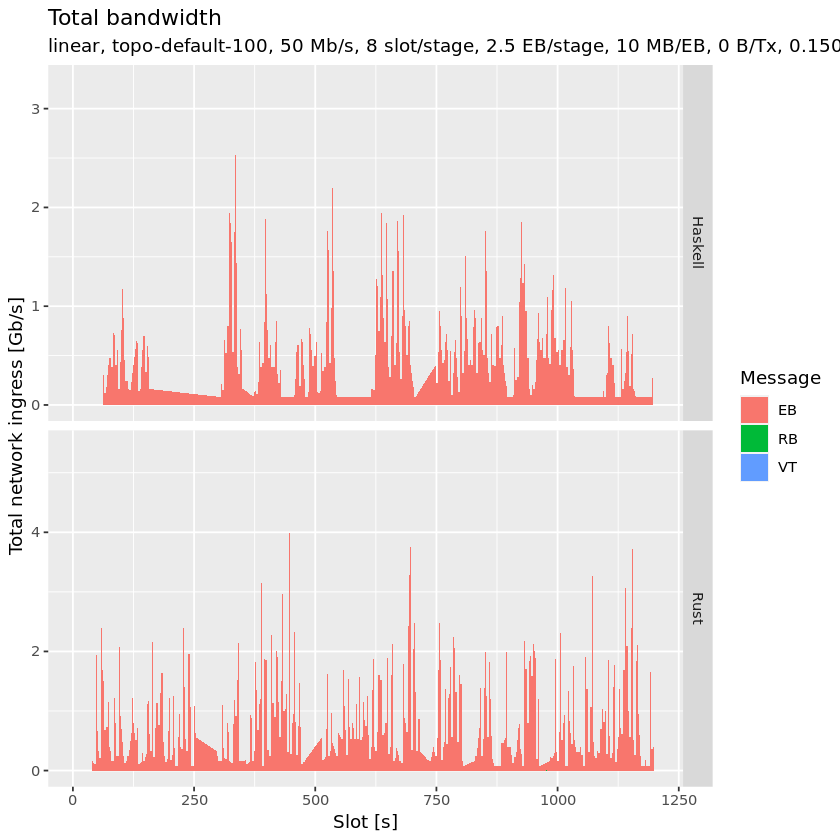

In [29]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    scales="free_y",
    outfiles=paste0("plots/ingress-total-area.png")
)

##### Bandwidth usage per node

In [30]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

[1] 100

In [31]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        substitute(
            rs[,
                .(`Size [Mb/node]`=8*sum(`Size [B]`)/1e6/ifelse(`Network`=="topology-v1",10000,750)/sampleSize),
                by=.(`Varied`, `Network`, `Slot`=floor(`Received [s]`), `Message`)
            ],
            env=list(`Varied`=sym(varied))
        ) %>% eval,
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_varied(scales=scales) +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

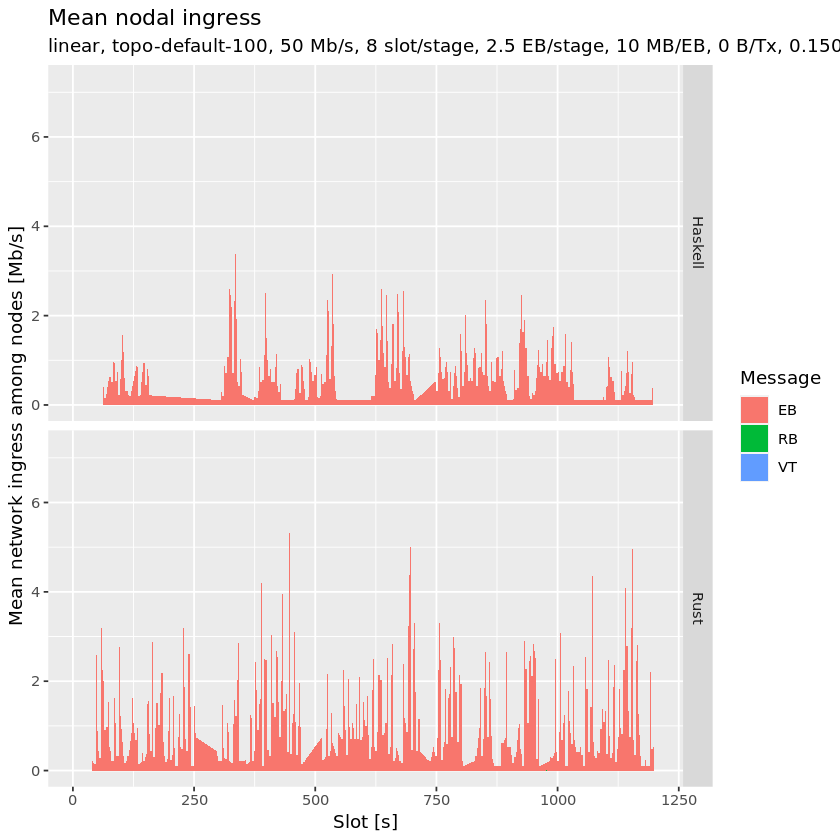

In [32]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    outfiles=paste0("plots/ingress-average-area.png")
)

In [33]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        substitute(
            rs[,
                .(`Size [Mb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e6/sampleSize),
                by=.(`Varied`, `Network`, `Slot`=floor(`Received [s]`), `Message`, `Recipient`)
            ][,
                .(`Size [Mb]`=max(`Size [Mb]`)),
                by=.(`Varied`, `Network`, `Slot`, `Message`)
            ],
            env=list(`Varied`=sym(varied))
        ) %>% eval,
        aes(x=`Slot`, y=`Size [Mb]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_varied(scales=scales) +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

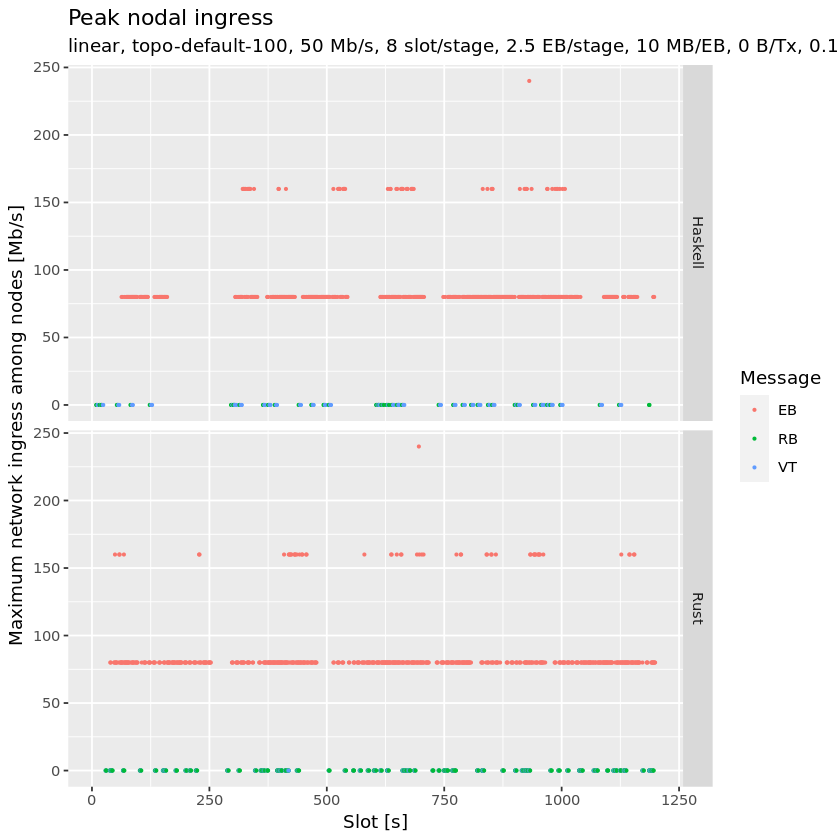

In [34]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/ingress-peak-point.png")
)

#### Release memory

In [35]:
rm(receipts)

In [36]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,994274,53.1,2526341,135.0,2526341,135.0
Vcells,2280521,17.4,8404990,64.2,8404990,64.2


### CPU usage

#### Read results

In [37]:
if (file.exists("results/cpus.Rdata")) {
    load(file="results/cpus.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    cpus <- fread("results/cpus.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(cpus, file="results/cpus.Rdata")
}
cpus[, `Stage length`:=factor(`Stage length`, levels=sort_factors(cpus[, unique(`Stage length`)]))]
cpus %>% summary

Loaded Rdata file: sampleSize = 1 


   Simulator       Variant                  Network        Bandwidth    
 Haskell:52291   linear:92006   topo-default-100:92006   50 Mb/s:92006  
 Rust   :39715                                                          
                                                                        
                                                                        
                                                                        
                                                                        
                                                                        
       Stage length           EB rate        Max EB size      Tx size     
 8 slot/stage:92006   2.5 EB/stage:92006   10 MB/EB:92006   0 B/Tx:92006  
                                                                          
                                                                          
                                                                          
                                         

In [38]:
cpusNode <-
    substitute(
        cpus[
            ,
            .(`Duration [s]`=sum(`Duration [s]`)),
            by=.(`Varied`, `Network`, `Node`, `Slot`)
        ],
        env=list(`Varied`=sym(varied))
    ) %>% eval

In [39]:
nodeCount <- cpusNode[, length(unique(`Node`))]
nodeCount

[1] 100

#### Peak CPU usage

##### Histogram

In [40]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        substitute(
            cs[,
                .(`Duration [%]`=100*max(`Duration [s]`)),
                by=.(`Varied`, `Network`, `Slot`)
            ], 
            env=list(`Varied`=sym(varied))
        ) %>% eval,
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_varied(scales=scales) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

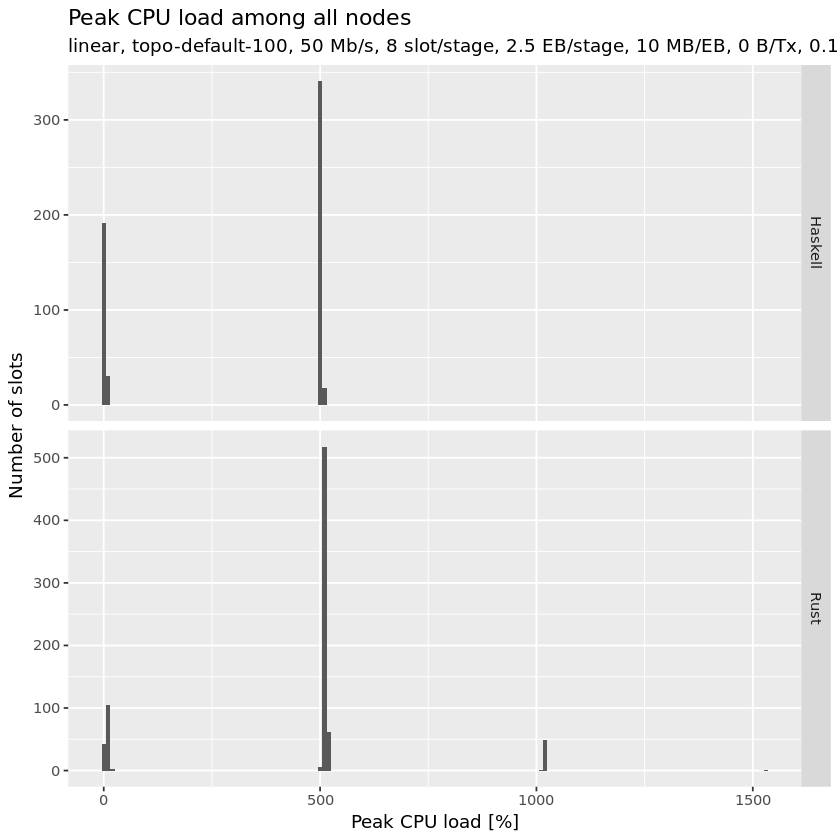

In [41]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/cpu-peak-histogram.png")
)

##### Time series

In [42]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        substitute(
            cs[,
                .(`Duration [%]`=100*mean(`Duration [s]`)/sampleSize),
                by=.(`Varied`, `Network`, `Slot`)
            ], 
            env=list(`Varied`=sym(varied))
        ) %>% eval,
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_varied(scale=scales) +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

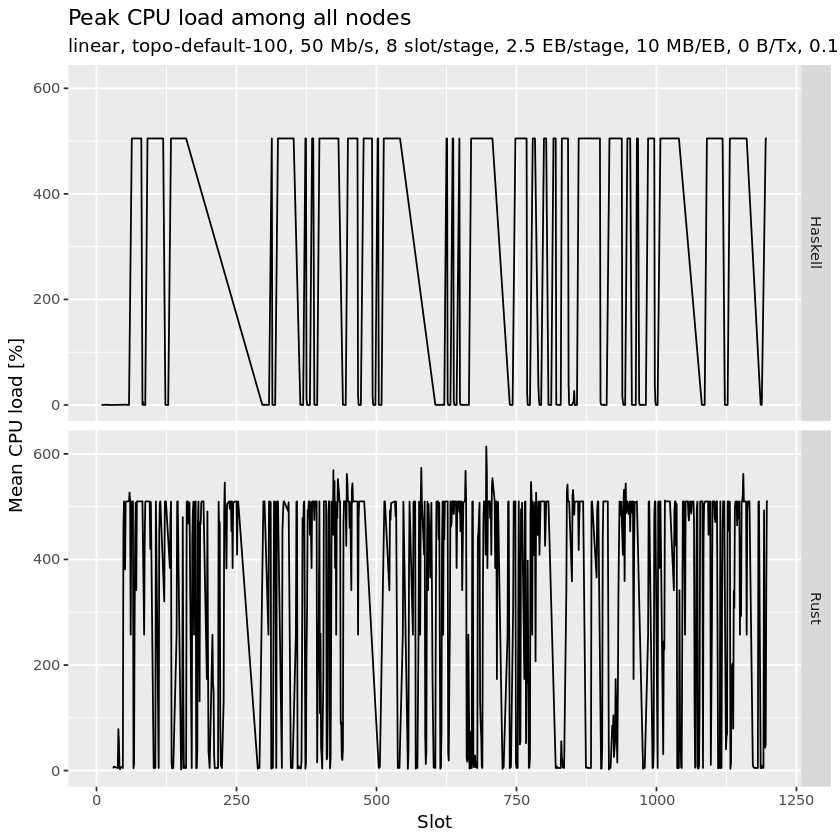

In [43]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [44]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        substitute(
            cs[,
                .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds/ifelse(`Network` == "topology-v1", 10000, 750)),
                by=.(`Varied`, `Network`, `Task`)
            ], 
            env=list(`Varied`=sym(varied))
        ) %>% eval,
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_varied(wide=TRUE, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

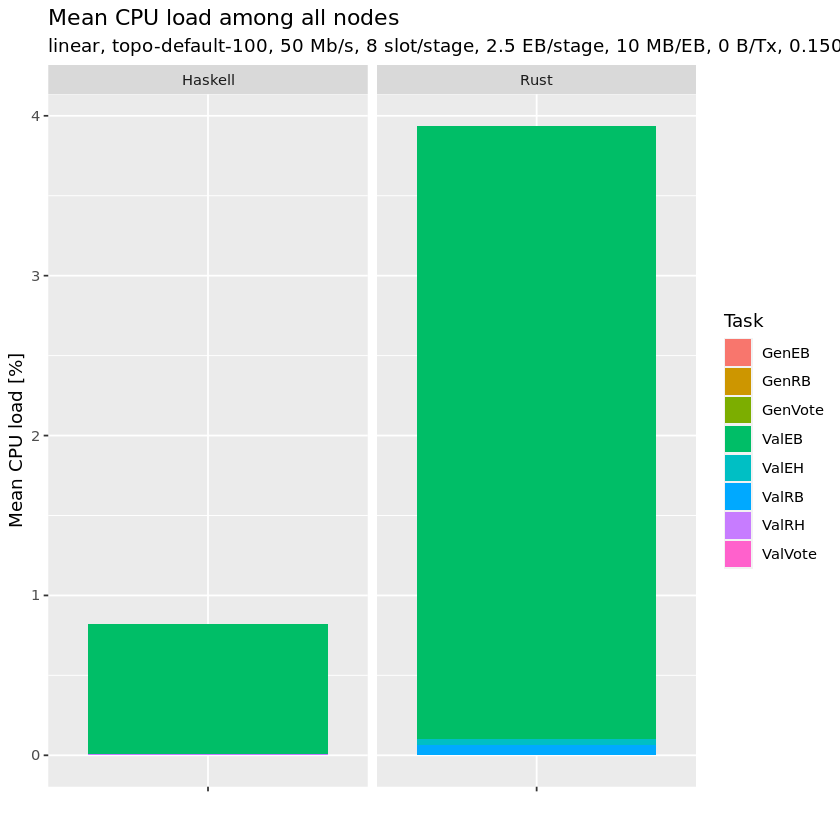

In [45]:
meanCpuHistogram(
    cpus,
    simFinish * sampleSize, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/cpu-mean-histogram.png")
)

##### Time series

In [46]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        substitute(
            cs[,
                .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds/ifelse(`Network`=="topology-v1",10000,750)/sampleSize),
                by=.(`Varied`, `Network`, `Slot`, `Task`)
            ], 
            env=list(`Varied`=sym(varied))
        ) %>% eval,
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_varied(scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

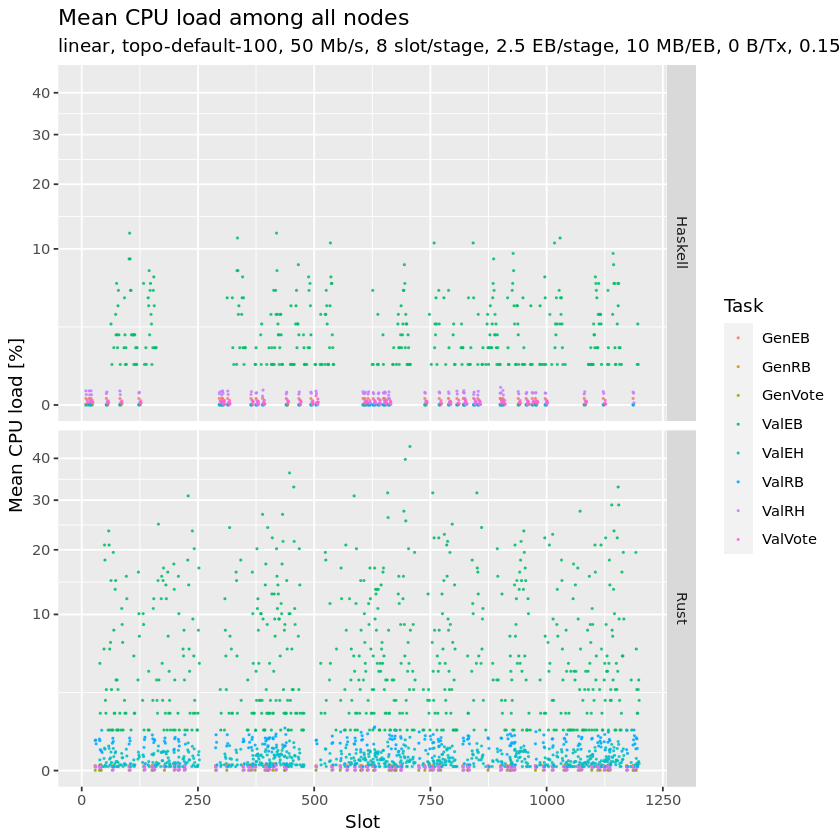

In [47]:
meanCpuTimeseries(
    cpus, 
    sampleSize, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/cpu-mean-timeseries.png")
)

#### Release memory

In [48]:
rm(cpus, cpusNode)

In [49]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1000274,53.5,2526341,135.0,2526341,135.0
Vcells,2630248,20.1,8404990,64.2,8404990,64.2
